<h2> Time series prediction</h2>
The following model is constructed to compare and contrast ARIMA and RNN in predicting time series<br>
We predict electricity generation from a wind mill.<br>
Here, we provide a step-by-step procedure to compare the performance of ARIMA and LSTM neural network

<h2> ARIMA for forecasting</h2>

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
% matplotlib inline
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.api as smt
import random
import numpy as np

/home/ashutosh/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<b> Data Input </b><br>
Reading the data as a list

In [2]:
data = pd.read_csv("/home/ashutosh/Desktop/dataset/timeSeries/dataPower.csv")
windPower = data['windPower'].tolist()

Splitting the data into train and test <br>
First 4 years data is treated as test and 5th year data is treated as test <br>
<b> Contrast to deep learning: </b><br>
The sample data cannot be randomized like it is done in typical machine learning (which we discuss in RNN model) as ARIMA is based on lagged correlation and the structure would break. Also, ARIMA uses errors as parameters in predicting the future values

In [3]:
trainData = windPower[0:(365*3+366)*24]
testData = windPower[(365*3+366)*24:len(windPower)]

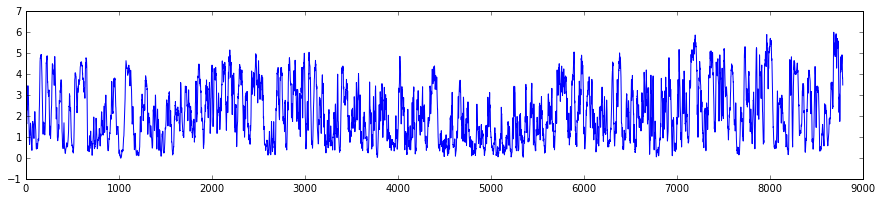

In [4]:
fig = plt.figure(figsize=(15, 3))
plt.plot(trainData[0:366*24])

<b><u>Fitting the ARIMA model</u></b><br>
Multiple models have been tried and the best model is selected<br>
1) first, ACF and PACF for the series is observed <br>
2) the plot shows that the model follows AR model as ACF is exponentially dying while PACF is cut-off

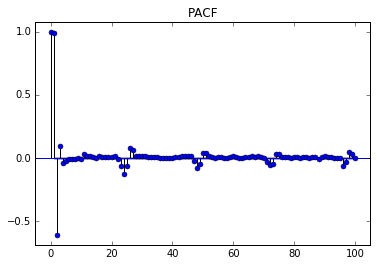

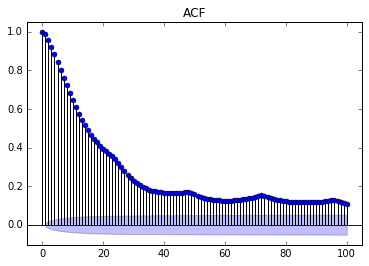

In [5]:
fig = plt.figure(figsize=(15, 3))
smt.graphics.plot_pacf(trainData, lags=100)
plt.title('PACF')
smt.graphics.plot_acf(trainData, lags=100)
plt.title('ACF')

We fit different models to find out the best fit. We define the best fit in terms of maximizng likelihood values while miniimizing AIC values. The model with minimum complexity is selected (minimum number of parameters as increasing the number of parameters increases the model complexity that leads to the model overfitting). <br> 
We check the ACF and PACF of the models for best fit. The best model seems to be ARIMA(3,0,0) that has minimum number of parameters among the better models.

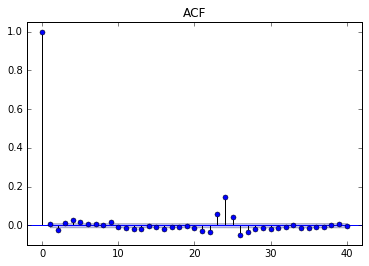

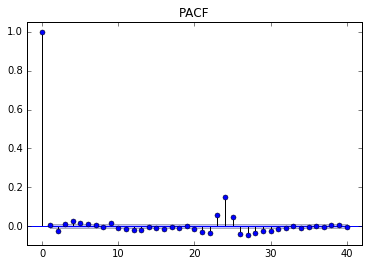

In [6]:
model = ARIMA(trainData, order=(3,0,0))
model_fit = model.fit(disp=0)
residuals = model_fit.resid

smt.graphics.plot_acf(residuals, lags=40)
plt.title('ACF')
smt.graphics.plot_pacf(residuals, lags=40)
plt.title('PACF')

In [7]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                35064
Model:                     ARMA(3, 0)   Log Likelihood               11703.967
Method:                       css-mle   S.D. of innovations              0.173
Date:                Mon, 04 Sep 2017   AIC                         -23397.934
Time:                        13:08:15   BIC                         -23355.610
Sample:                             0   HQIC                        -23384.454
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2735      0.049     46.311      0.000       2.177       2.370
ar.L1.y        1.6465      0.005    309.829      0.000       1.636       1.657
ar.L2.y       -0.7640      0.009    -81.028      0.000      -0.782      -0.746
ar.L3.y        0.0987      0.005     18.572      0.000       0.088       0.109
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0480           +0.0000j            1.0480            0.0000
AR.2            2.1091           +0.0000j            2.1091            0.0000
AR.3            4.5838           +0.0000j            4.5838            0.0000
-----------------------------------------------------------------------------
"""

The above graph shows that there is a seasonality component in the model. Seasonality appears to be in the 24rth, which makes sense as hourly data is collected. Also, acf and pacf values increase around the 24th lag

Since seasonlaity is observed in the data, we build a seasonal ARIMA (SARIMA) model

<b>SARIMA Model</b><br>
Based on the ARIMA(3,0,0) model and seasonality factor, a SARIMA model is proposed<br>
The best model obtained is ARIMA(3,0,0)x(1,0,1,24). By looking into the ACF and PACF values, the model seems appropriate<br>
However, using prediction, ARIMA(3,0,0)x(1,0,0,24) seems a better model as it easier to predict, less complex and performs etter in prediction than ARIMA (3,0,0)x(1,0,1,24) may be because the later model is overfitting and performs poorly for unseen data.

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                35064
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 24)   Log Likelihood               11819.341
Date:                            Mon, 04 Sep 2017   AIC                         -23628.681
Time:                                    13:12:20   BIC                         -23586.357
Sample:                                         0   HQIC                        -23615.201
                                          - 35064                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6478      0.004    461.926      0.000       1.641       1.655
ar.L2         -0.7428      0.006   

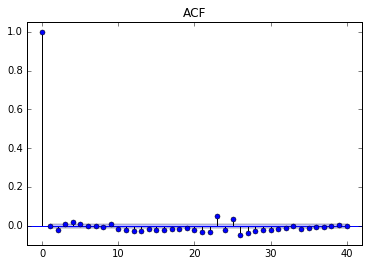

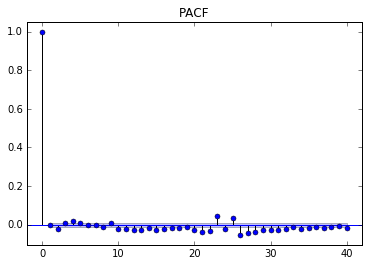

In [8]:
model = smt.SARIMAX(trainData, order=(3,0,0), seasonal_order=(1,0,0,24))
model_fit = model.fit(disp=0)
residuals = model_fit.resid

smt.graphics.plot_acf(residuals, lags=40)
plt.title('ACF')
smt.graphics.plot_pacf(residuals, lags=40)
plt.title('PACF')
print model_fit.summary()

Predicting the wind power for the next year using previous data <br>
The Equation becomes: $x_t=\phi_1x_{t-1}-\phi_1\phi_{24}x_{t-25}+\phi_{2}x_{t-2}-\phi_2\phi_{24}x_{t-26}+\phi_3x_{t-3}-\phi_3\phi_{24}x_{t-27}+\phi_{24}x_{t-24}+a_t$ <br>
$\phi_1$: 1.6478<br>
$\phi_2$: -0.7428<br>
$\phi_3$: 0.0886<br>
$\phi_{24}$: 0.1523<br>
$\sigma^{2}$: 0.0280<br>

We develop both the models to check the performance. We name them as:<br>
1) model1 = SARIMAX(3, 0, 0)x(1, 0, 1, 24) <br>
2) model2 = SARIMAX(3, 0, 0)x(1, 0, 0, 24) 

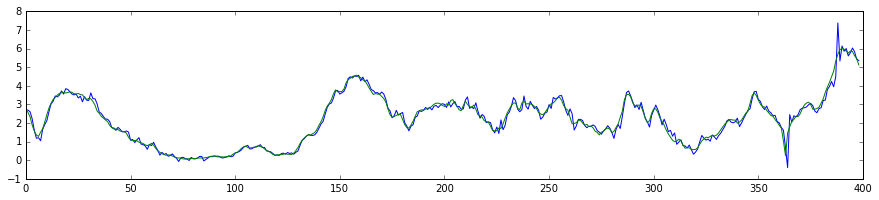

In [10]:
predict_ = model_fit.predict()

# if selecting model1, use model1 = 1 or 0
model1 = 1

predict = []

if model1 == 1:
    a = [0]*24     # a is used to keep track of the MA error
    p1 = 1.6004
    p2 = -0.6560
    p3 = 0.0368
    p24 = 0.9890
    # best value for seasonal MA (obtained using hit and trial as orginal value was 0.9296)
    # increasing the value of t24 makes the prediction non-smooth and very sensitive (Swiggly)
    t24 = -0.09296 
    
    for i in range(27,len(windPower)):
        v = 0
        v += p1*windPower[i-1]
        v -= p1*p24*windPower[i-25]
        v += p2*windPower[i-2]
        v -= p2*p24*windPower[i-26]
        v += p3*windPower[i-3]
        v -= p3*p24*windPower[i-27]
        v += p24*windPower[i-24]
        v -= t24*a[0]
        predict.append(v)
        a.pop(0)
        a.append(windPower[i]-v)
    
else:
    p1 = 1.6478
    p2 = -0.7428
    p3 = 0.0886
    p24 = 0.1523
    
    for i in range(27,len(windPower)):
        v = 0
        v += p1*windPower[i-1]
        v -= p1*p24*windPower[i-25]
        v += p2*windPower[i-2]
        v -= p2*p24*windPower[i-26]
        v += p3*windPower[i-3]
        v -= p3*p24*windPower[i-27]
        v += p24*windPower[i-24]
        predict.append(v)

# for checking the prediction
fig = plt.figure(figsize=(15, 3))
plt.plot(predict[-400:-1],'b')
plt.plot(windPower[-400:-1],'g')

------------------------------------------------------------------

<h2>RNN for forecasting</h2>
The following part is used to understand the working of RNN for time series prediction<br>
<br>
A LSTM network  with two layers is developed for prediction.<br>
A full batch is used for gradient descent (Adam optimizer)

In [11]:
import numpy as np
import tensorflow as tf

First step is constructing the data in the format.<br>
The data is shaped into [None,27,1] where a row (sample) contains "27" time sequence of size "1". <br>
We use 27 as it was seen in ARIMA model that as far as 27 time sequences are required for modelling (24+3 for ARIMA)


In [12]:
data = pd.read_csv("/home/ashutosh/Desktop/dataset/timeSeries/dataPower.csv")
X = []
Y = []

for i in range(len(windPower)-28):
    data = windPower[i:i+28]
    a = []
    for j in range(27):
        a.append([data[j]])
    X.append(a)
    Y.append([data[27]])
X = np.array(X)
Y = np.array(Y)

<b> Contrast to the ARIMA model</b><br>
In RNN, data samples can be randomized unlike ARIMA models as Y depends only on the corresponding sequence

In [13]:
train_indices = np.random.choice(len(X), int(len(X)*0.8), replace=False)
test_indices  = np.array(list(set(range(len(X))) - set(train_indices)))

trainX = X[train_indices]
testX  = X[test_indices]
trainY = Y[train_indices]
testY  = Y[test_indices]

In [14]:
# setting the random seed for reproducibility
seed = 0
tf.set_random_seed(seed)
np.random.seed(seed)

seq_length: number of time steps we are looking at<br>
data_dim: number of points in 1 time step<br>
n_layers: number of lstm layers<br>
hidden_dim: number of lstm cells<br>
output_dim: number of time steps for forecast

In [15]:
# Network Parameters
seq_length = 27
data_dim = 1
hidden_dim = 30
output_dim = 1

Graph input for tensorflow<br>
learningRate can also be changed with iterations

In [16]:
X = tf.placeholder(tf.float32, [None, seq_length, data_dim],name="X_placeholder")
Y = tf.placeholder(tf.float32, [None, 1],name="Y_placeholder")
learningRate = tf.placeholder('float',name="rate")

Building a LSTM network with one layer


In [17]:
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

Loss functions and optimizer

In [18]:
loss = tf.reduce_mean(tf.square(Y_pred - Y))  # sum of the squares
optimizer = tf.train.AdamOptimizer(learningRate)
train = optimizer.minimize(loss)

In [19]:
# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

Setting the parameters

In [20]:
rate = 0.01
iterations = 100

In [21]:
# Initialize the loss vectors
train_loss = []
test_loss = []

In [22]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

Starting the session

[step: 0] loss: 8.2279882431
[step: 1] loss: 5.41217851639
[step: 2] loss: 3.42405772209
[step: 3] loss: 2.06885671616
[step: 4] loss: 1.3500084877
[step: 5] loss: 1.24884331226
[step: 6] loss: 1.25480866432
[step: 7] loss: 0.999310135841
[step: 8] loss: 0.642490327358
[step: 9] loss: 0.433229833841
[step: 10] loss: 0.445751190186
[step: 11] loss: 0.516238570213
[step: 12] loss: 0.510272800922
[step: 13] loss: 0.42181417346
[step: 14] loss: 0.306144535542
[step: 15] loss: 0.231491357088
[step: 16] loss: 0.229951113462
[step: 17] loss: 0.263065159321
[step: 18] loss: 0.262398451567
[step: 19] loss: 0.214805796742
[step: 20] loss: 0.162950158119
[step: 21] loss: 0.145016312599
[step: 22] loss: 0.156926244497
[step: 23] loss: 0.167630940676
[step: 24] loss: 0.157453179359
[step: 25] loss: 0.133581772447
[step: 26] loss: 0.117237560451
[step: 27] loss: 0.11981395632
[step: 28] loss: 0.128790527582
[step: 29] loss: 0.126204833388
[step: 30] loss: 0.112560719252
[step: 31] loss: 0.1014476418

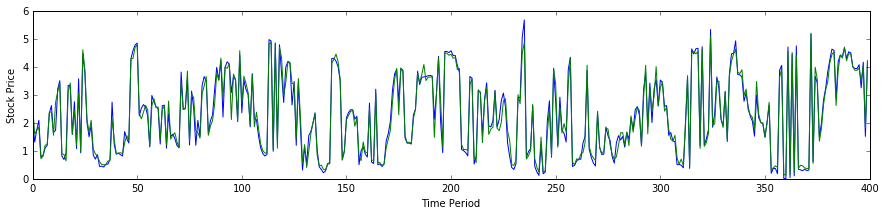

In [24]:
with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)
    #saver.restore(sess, "/home/ashutosh/Dropbox/Git/timeseries/model.ckpt")
    step = 1
    epoch = 1

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
            X: trainX, Y: trainY, learningRate:rate})
        print("[step: {}] loss: {}".format(i, step_loss))

        if (i + 1)== iterations:
            save_path = saver.save(sess, "/home/ashutosh/Dropbox/Git/timeseries/model.ckpt")

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX[0:400]})
    rmse_val = sess.run(rmse, feed_dict={
        targets: testY[0:400], predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    fig = plt.figure(figsize=(15, 3))
    plt.plot(testY[0:400])
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

The graphs for both ARIMA and RNN shows that the forecast from both the models are reasonably good<br>
Also the coputational time is low. Since wind power generation from the farms are seemingly stationary, RNN performs good. In case of non-stationary time series, ARIMA and RNN can be integrated to develop better prediction models